In [22]:
!pip install -q mne scipy scikit-learn pandas matplotlib seaborn

In [23]:
import mne
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from mne.filter import filter_data

All libraries imported


In [24]:
from google.colab import files

uploaded = files.upload()

FILENAME = list(uploaded.keys())[0]
print("Working with file:", FILENAME)

Saving Player_sub06_Observer_sub03.mat to Player_sub06_Observer_sub03 (2).mat
Working with file: Player_sub06_Observer_sub03 (2).mat


In [25]:
import scipy.io as sio
mat = sio.loadmat(FILENAME, squeeze_me=True, struct_as_record=False)
player = mat['player']

fs          = player.fs
eeg_raw     = player.x
label_mat   = player.y
class_names = [str(c) for c in player.className.squeeze()]

print("Sampling rate fs          :", fs)
print("EEG raw shape             :", eeg_raw.shape)
print("Label matrix shape        :", label_mat.shape)
print("Class names (row order)   :", class_names)

labels = label_mat.argmax(axis=0).astype(int)
print("Labels vector shape       :", labels.shape,
      "unique codes:", np.unique(labels))

Sampling rate fs          : 100
EEG raw shape             : (350, 30, 484)
Label matrix shape        : (4, 484)
Class names (row order)   : ['sponL', 'sponT', 'instL', 'instT']
Labels vector shape       : (484,) unique codes: [0 1 2 3]


In [26]:
eeg_data = np.transpose(eeg_raw, (2, 1, 0))
print("eeg_data shape (T, C, time):", eeg_data.shape)

eeg_data shape (T, C, time): (484, 30, 350)


In [27]:
from mne.filter import filter_data

sfreq = fs
reshaped = eeg_data.reshape(-1, eeg_data.shape[2])
filtered = filter_data(reshaped, sfreq=sfreq, l_freq=1., h_freq=40., verbose=False)
eeg_filt = filtered.reshape(eeg_data.shape)

print("Filtered EEG shape:", eeg_filt.shape)

Filtered EEG shape: (484, 30, 350)


In [28]:
import mne

bands = {
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta" : (13, 30),
    "gamma": (30, 40)
}

n_bands   = len(bands)
n_trials  = eeg_filt.shape[0]
n_chans   = eeg_filt.shape[1]
feat_bp   = np.zeros((n_trials, n_chans * n_bands))

for b_idx, (band_name, (fmin, fmax)) in enumerate(bands.items()):
    psd, freqs = mne.time_frequency.psd_array_welch(
        eeg_filt, sfreq=sfreq, fmin=fmin, fmax=fmax,
        n_fft=256, verbose=False
    )
    band_power = psd.mean(axis=2)
    feat_bp[:, b_idx*n_chans:(b_idx+1)*n_chans] = band_power

print("Band‑power feature matrix:", feat_bp.shape)

Band‑power feature matrix: (484, 120)


              precision    recall  f1-score   support

       sponL       0.63      0.73      0.68        26
       sponT       0.63      0.52      0.57        23

    accuracy                           0.63        49
   macro avg       0.63      0.63      0.62        49
weighted avg       0.63      0.63      0.63        49



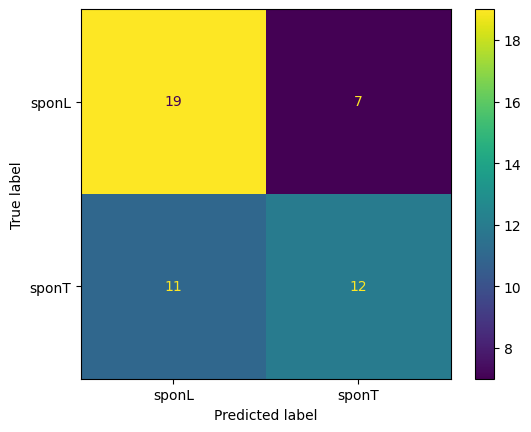

<Figure size 640x480 with 0 Axes>

In [30]:
X_bp = feat_bp[mask]
y_bp = labels[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_bp, y_bp, test_size=0.2, random_state=42, stratify=y_bp)

clf_bp = RandomForestClassifier(
    n_estimators=400, max_depth=None, random_state=42)
clf_bp.fit(X_train, y_train)

y_pred_bp = clf_bp.predict(X_test)
print(classification_report(
    y_test, y_pred_bp,
    target_names=[class_names[0], class_names[1]]))

ConfusionMatrixDisplay.from_estimator(
    clf_bp, X_test, y_test,
    display_labels=[class_names[0], class_names[1]])
plt.show()

plt.savefig("confmat.png", dpi=300, bbox_inches="tight")